In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fitsio
import glob

In [2]:
def compute_entropy_1d(x):
    n_steps = len(x)//4 - 1
    proba = {}
    for i in range(n_steps):
        d = x[i*4:(i+1)*4]
        l = list(np.argsort(d))
        l = ''.join(str(e) for e in l)
        try:
            proba[l] += 1
        except:
            proba[l] = 1
    p = np.array(list(proba.values()))
    p = p/p.sum()
    h = np.sum(-p*np.log2(p))/np.log2(24)
    return h

In [3]:
fuji_path = "/global/cfs/cdirs/desi/spectro/redux/guadalupe/"
data_tiles_fuji = fitsio.read(os.path.join(fuji_path, "tiles-guadalupe.fits"))

In [4]:
data_tiles_fuji.dtype

dtype([('TILEID', '>i4'), ('SURVEY', '<U20'), ('PROGRAM', '<U6'), ('FAPRGRM', '<U20'), ('FAFLAVOR', '<U20'), ('NEXP', '>i8'), ('EXPTIME', '>f8'), ('TILERA', '>f8'), ('TILEDEC', '>f8'), ('EFFTIME_ETC', '>f8'), ('EFFTIME_SPEC', '>f8'), ('EFFTIME_GFA', '>f8'), ('GOALTIME', '>f8'), ('OBSSTATUS', '<U20'), ('LRG_EFFTIME_DARK', '>f8'), ('ELG_EFFTIME_DARK', '>f8'), ('BGS_EFFTIME_BRIGHT', '>f8'), ('LYA_EFFTIME_DARK', '>f8'), ('GOALTYPE', '<U20'), ('MINTFRAC', '>f8'), ('LASTNIGHT', '>i4')])

In [5]:
def summary_tile_stats(tile_id, last_night):
    n_gal_list = []
    n_star_list = []
    n_qso_list = []
    z_entropy = []
    petal_list = [] 
    for petal_id in range(10):
        search_path = "{}/tiles/cumulative/{}/*/redrock-0-{}-thru*.fits".format(fuji_path, tile_id, tile_id)
        file_in = glob.glob(search_path)
        tile_file = file_in[0].replace("redrock-0", "redrock-{}".format(petal_id))
        #print(tile_file)
        #tile_file = "{}/tiles/cumulative/{}/{}/redrock-{}-{}-thru{}.fits".format(
        #    fuji_path, tile_id, last_night, petal_id, tile_id, last_night)
        #print(tile_file)
        try:
            z_tile_per_exp = fitsio.read(tile_file, ext="REDSHIFTS")
            fmap_tile_per_exp = fitsio.read(tile_file, ext="FIBERMAP")
            exp_fmap_tile_per_exp = fitsio.read(tile_file, ext="EXP_FIBERMAP")
        except:
            pass
        try:
            ii = (z_tile_per_exp['ZWARN']==0) & (exp_fmap_tile_per_exp['FIBERSTATUS']==0)
            h = compute_entropy_1d(z_tile_per_exp['Z'][ii])
            n_gal = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='GALAXY')
            n_star = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='STAR')
            n_qso = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='QSO')
        
            petal_list.append(petal_id)
            z_entropy.append(h)
            n_gal_list.append(n_gal)
            n_star_list.append(n_star)
            n_qso_list.append(n_qso)
        except:
            pass
    return {'petal_id':petal_list, 'z_entropy':z_entropy, 'n_gal':n_gal_list, 'n_star':n_star_list, 'n_qso':n_qso_list}

In [6]:
tile_index = 100
print(data_tiles_fuji['SURVEY'][tile_index])
summary_tile_stats(data_tiles_fuji['TILEID'][tile_index], data_tiles_fuji['LASTNIGHT'][tile_index])

main


{'petal_id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'z_entropy': [0.9595778487059644,
  0.9703913340334578,
  0.9800543929780611,
  0.9724071743622233,
  0.9794775571782881,
  0.9487284520530515,
  0.9745953060585925,
  0.947660317189635,
  0.966593960721486,
  0.9597558846339665],
 'n_gal': [381, 350, 352, 324, 325, 361, 317, 294, 330, 353],
 'n_star': [55, 45, 64, 64, 64, 40, 44, 59, 79, 67],
 'n_qso': [2, 3, 3, 3, 5, 6, 4, 3, 2, 2]}

In [27]:
n_tiles = len(data_tiles_fuji)
print(n_tiles)
h = 'TILEID,PROGRAM,PETALID,H,N_GAL,N_STAR,N_QSO\n'
out = open('summary_guadalupe.csv', 'w')
out.write(h)
for i in range(100):
    if data_tiles_fuji['SURVEY'][i]=='main':
        a = summary_tile_stats(data_tiles_fuji['TILEID'][i], data_tiles_fuji['LASTNIGHT'][i])
        #print(a)
        if len(a['petal_id']):
            n_p = len(a['petal_id'])
            for j in range(n_p):
                s = '{},{},{},{},{},{},{}\n'.format(data_tiles_fuji['TILEID'][i], 
                                                    data_tiles_fuji['PROGRAM'][i],
                                                 a['petal_id'][j],a['z_entropy'][j],
                                     a['n_gal'][j], a['n_star'][j], a['n_qso'][j])
                out.write(s)
out.close()

653


In [16]:
import pandas as pd

In [30]:
summary = pd.read_csv("summary_guadalupe.csv")

(0.88, 1.0)

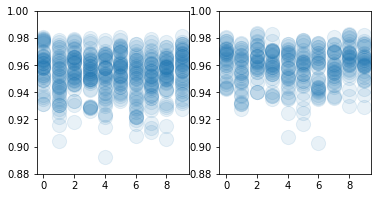

In [45]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['H'][ii], alpha=0.1, s=200)
plt.ylim([0.88,1.0])

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['H'][ii], alpha=0.1, s=200)
plt.ylim([0.88,1.0])

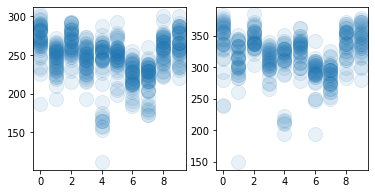

In [40]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['N_GAL'][ii], alpha=0.1, s=200)

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['N_GAL'][ii], alpha=0.1, s=200)

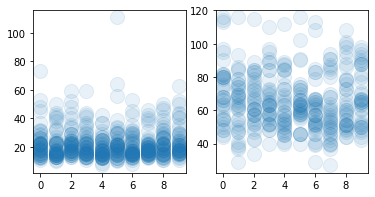

In [41]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['N_STAR'][ii], alpha=0.1, s=200)

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['N_STAR'][ii], alpha=0.1, s=200)

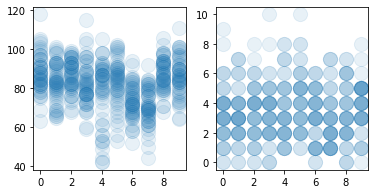

In [42]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
ii=summary['PROGRAM']=='dark'
plt.scatter(summary['PETALID'][ii], summary['N_QSO'][ii], alpha=0.1, s=200)

plt.subplot(1,2,2)
ii=summary['PROGRAM']=='bright'
plt.scatter(summary['PETALID'][ii], summary['N_QSO'][ii], alpha=0.1, s=200)

In [ ]:
#[('TARGETID', '>i8'), ('Z', '>f8'), ('ZERR', '>f8'), ('ZWARN', '>i8'), ('CHI2', '>f8'), ('COEFF', '>f8', (10,)), ('NPIXELS', '>i8'), 
# ('SPECTYPE', '<U6'), ('SUBTYPE', '<U20'), ('NCOEFF', '>i8'), ('DELTACHI2', '>f8')])


In [ ]:
len(z_tile_per_exp['Z'])

In [ ]:
list(z_tile_per_exp['SPECTYPE'][ii])

In [ ]:
fmap_tile_per_exp.dtype

In [ ]:
plt.scatter(fmap_tile_per_exp['TARGET_RA'], fmap_tile_per_exp['TARGET_DEC'])

In [ ]:
exp_fmap_tile_per_exp['FIBERSTATUS']